# Tree boosting for conditional density estimation

In [15]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LogisticRegression


Define the class of binary tree

In [16]:
class TreeNode:
    def __init__(self, left=None, right=None, split = None, pleft = None, left_bound = None, right_bound = None, theta = None):
        self.left = left
        self.right = right
        self.split = split
        self.pleft = pleft
        self.left_bound = left_bound
        self.right_bound = right_bound
        self.theta = theta
    def treecdf_A(self, x):
        if x <= self.left_bound or x > self.right_bound:
            return None
        mu_left = (self.split - self.left_bound) / (self.right_bound - self.left_bound)
        if not self.split or not self.pleft:
            return x
        if x <= self.split:
            return self.pleft/mu_left * (x - self.left_bound) + self.left_bound
        else:
            mu_right = 1 - mu_left
            return (1 - self.pleft)/mu_right * (x - self.right_bound) + self.right_bound
    def treecdf(self, x):
        if x <= self.left_bound or x > self.right_bound:
            return None
        if not self.left and not self.right:
            return self.treecdf_A(x)
        else:
            x_left, x_right = self.left.treecdf(x), self.right.treecdf(x)
            if x_left:
                x_new = x_left
            elif x_right:
                x_new = x_right
            else:
                return None
            return self.treecdf_A(x_new)
    def scalar_density(self, x):
        if not self.left and not self.right:
            return 1
        else:
            if x <= self.split:
                return self.pleft * self.left.scalar_density(x)
            else:
                return (1 - self.pleft) * self.right.scalar_density(x)
def make_copy(from_tree: TreeNode, to_tree: TreeNode):
        if not from_tree:
            return None
        to_tree.split = from_tree.split
        to_tree.pleft = from_tree.pleft
        to_tree.left_bound = from_tree.left_bound
        to_tree.right_bound = from_tree.right_bound
        to_tree.theta = from_tree.theta
        if from_tree.left:
            to_tree.left = TreeNode()
            make_copy(from_tree.left, to_tree.left)
        if from_tree.right:
            to_tree.right = TreeNode()
            make_copy(from_tree.right, to_tree.right)


In [17]:
def helper(node, x):
    """Calculate the branching probabilities from coefficients of Logistic regression and assign to nodes
    Args:
        node (TreeNode): tree
        x: estimated parameters from Logistic regression
    """
    if not node or not node.theta:
        return None
    else:
        node.pleft = 1.0 / (1 + np.exp(node.theta[0][0] + x * node.theta[1][0][0]))
        helper(node.left, x)
        helper(node.right, x)

## A simplied case

As a starting point, we implement a simplified case: 
- Always split *in the middle*, and fit Logistic regression at each node to link the tree CDF with covariate X
- X and Y are both univariate
- Depth of the trees is fixed and there is no other stopping rule, so a *full* tree is generated for each weak learner.

In the following examples, we plot the residuals after each iteration. 

Note: the loss function used in `LogisticRegression` of sklearn is logistic loss + l2 penalty. 

### Example 1: Bivariate normal (X, Y)

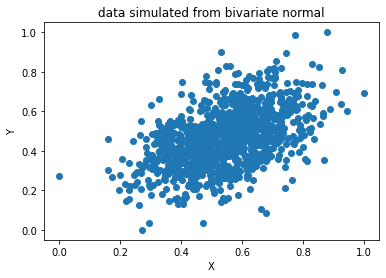

In [18]:
n = 1000
rho = 0.5
X = np.random.normal(0.0, 1, n)
Y = rho * X + np.sqrt(1 - rho**2) * np.random.normal(0.0, 1, n) 
X = (X - min(X))/(max(X) - min(X)) * 0.9999 + 0.00005
Y = (Y - min(Y))/(max(Y) - min(Y)) * 0.9999 + 0.00005
plt.scatter(X, Y);
plt.xlabel('X')
plt.ylabel('Y')
plt.title('data simulated from bivariate normal')
Y0 = Y.copy()

Residualization

Depth of the trees is set to 1.

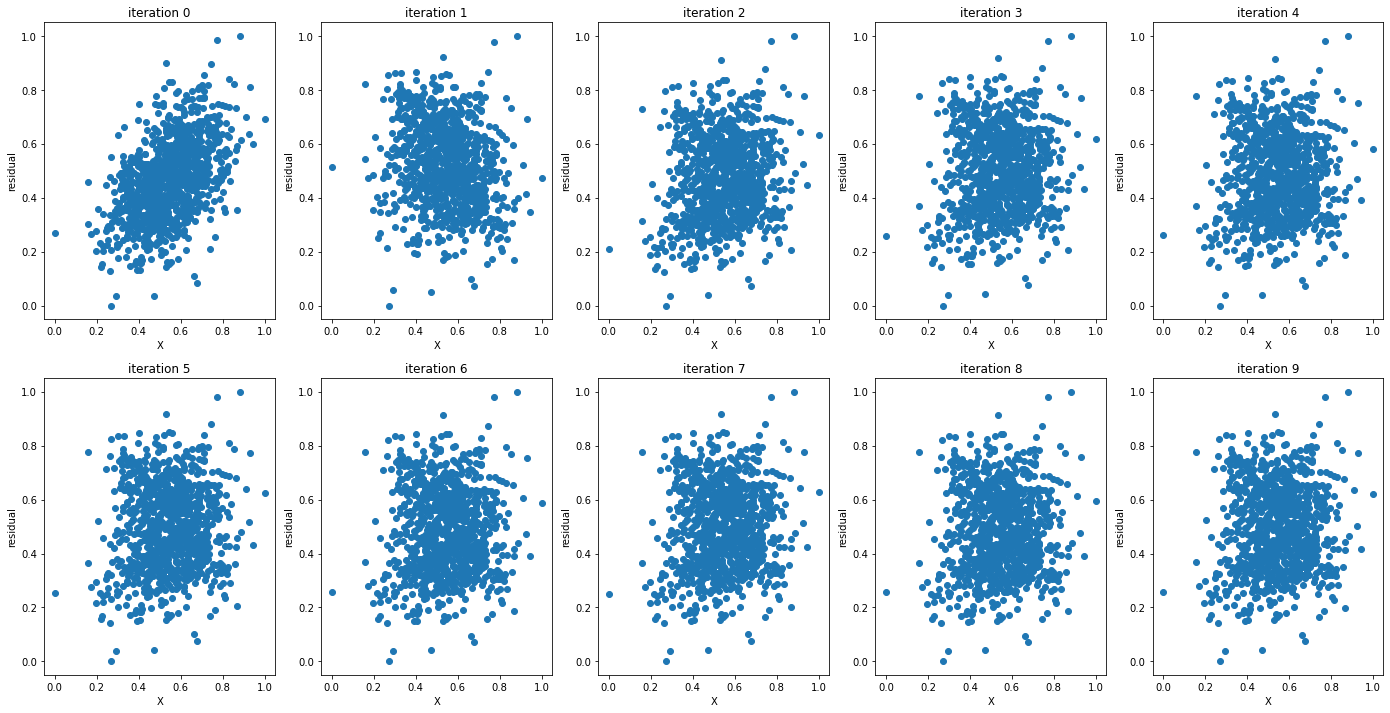

In [19]:
res = Y0.copy()
plt.figure(figsize=(24, 12))
for iter in range(10): 
    plt.subplot(2, 5, iter + 1);
    plt.scatter(X, np.array(res).reshape(len(res)), label = iter);
    plt.title(f'iteration {iter}');
    plt.xlabel('X');
    plt.ylabel('residual');
    Y = np.array(res.copy())
    for max_depth in [1]:
        tree = TreeNode(split = 0.5, left_bound=0, right_bound=1)
        curr_depth = 1
        # level traversal
        queue = [tree]
        while curr_depth <= max_depth and queue:
            l = len(queue)
            for i in range(l):
                node = queue.pop(0)
                if np.sum(np.logical_and(Y > node.left_bound, Y <= node.right_bound)) == 0:
                    node.pleft = 0.5
                elif np.sum(np.logical_and(Y > node.left_bound, Y <= node.split)) == 0:
                    node.pleft = 0.0
                elif np.sum(np.logical_and(Y > node.split, Y <= node.right_bound)) == 0:
                    node.pleft = 1.0
                else:
                    model = LogisticRegression(solver='liblinear', random_state=0)
                    local_index = np.logical_and(Y > node.left_bound, Y <= node.right_bound)
                    y_local = Y[local_index]
                    x_local = X[local_index]
                    model.fit(x_local.reshape(-1, 1), (y_local > node.split).astype('int'))
                    node.theta = [model.intercept_, model.coef_]
                    # node.pleft = model.predict_proba(x_local)[:,0]
                node.left = TreeNode(split = (node.left_bound + node.split)/2, left_bound=node.left_bound, right_bound=node.split)
                node.right = TreeNode(split = (node.right_bound + node.split)/2, left_bound=node.split, right_bound=node.right_bound)
                queue.append(node.left)
                queue.append(node.right)
            curr_depth += 1
    res = []
    for i, x in enumerate(X):
        tree_tmp = TreeNode()
        make_copy(tree, tree_tmp)
        helper(tree_tmp, x)
        res.append(tree_tmp.treecdf(Y[i]))


depth=4

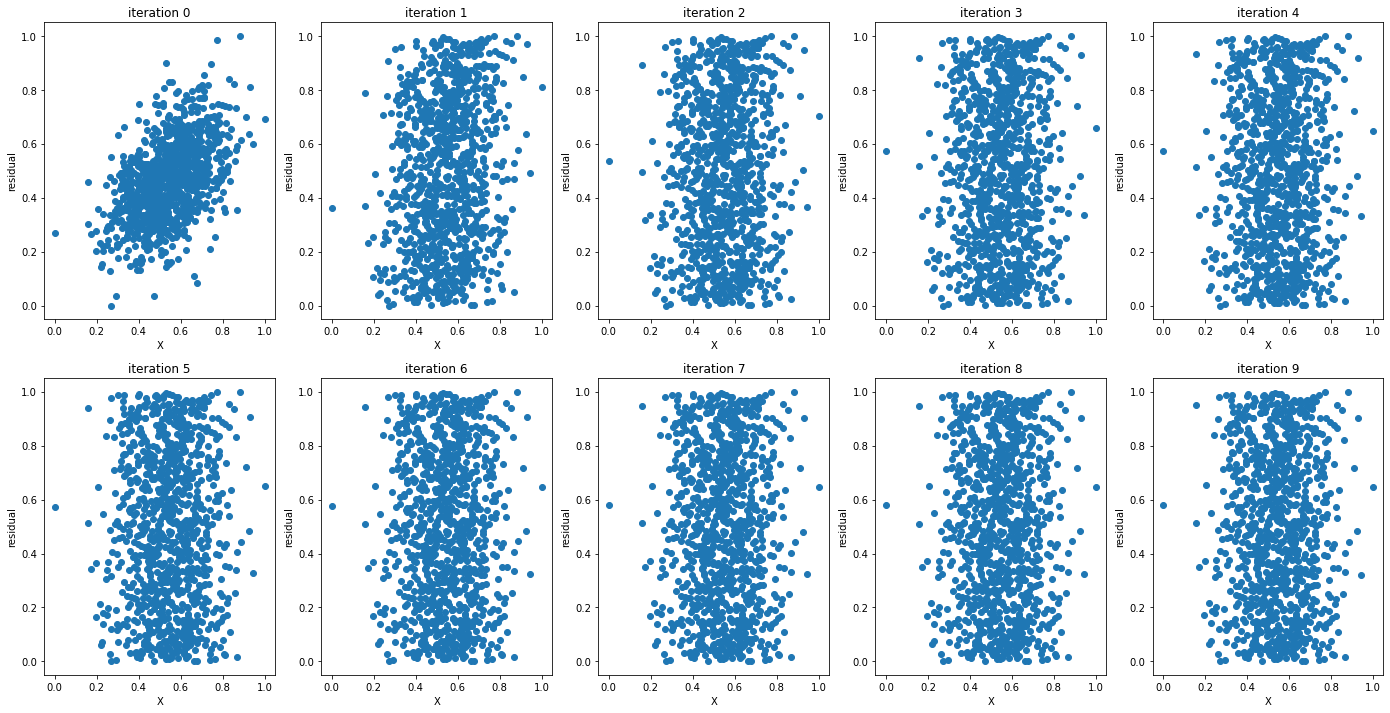

In [20]:
res = Y0.copy()
plt.figure(figsize=(24, 12))
for iter in range(10): 
    plt.subplot(2, 5, iter + 1);
    plt.scatter(X, np.array(res).reshape(len(res)), label = iter);
    plt.title(f'iteration {iter}');
    plt.xlabel('X');
    plt.ylabel('residual');
    Y = np.array(res.copy())
    for max_depth in [4]:
        tree = TreeNode(split = 0.5, left_bound=0, right_bound=1)
        curr_depth = 1
        # level traversal
        queue = [tree]
        while curr_depth <= max_depth and queue:
            l = len(queue)
            for i in range(l):
                node = queue.pop(0)
                if np.sum(np.logical_and(Y > node.left_bound, Y <= node.right_bound)) == 0:
                    node.pleft = 0.5
                elif np.sum(np.logical_and(Y > node.left_bound, Y <= node.split)) == 0:
                    node.pleft = 0.0
                elif np.sum(np.logical_and(Y > node.split, Y <= node.right_bound)) == 0:
                    node.pleft = 1.0
                else:
                    model = LogisticRegression(solver='liblinear', random_state=0)
                    local_index = np.logical_and(Y > node.left_bound, Y <= node.right_bound)
                    y_local = Y[local_index]
                    x_local = X[local_index]
                    model.fit(x_local.reshape(-1, 1), (y_local > node.split).astype('int'))
                    node.theta = [model.intercept_, model.coef_]
                    # node.pleft = model.predict_proba(x_local)[:,0]
                node.left = TreeNode(split = (node.left_bound + node.split)/2, left_bound=node.left_bound, right_bound=node.split)
                node.right = TreeNode(split = (node.right_bound + node.split)/2, left_bound=node.split, right_bound=node.right_bound)
                queue.append(node.left)
                queue.append(node.right)
            curr_depth += 1
    res = []
    for i, x in enumerate(X):
        tree_tmp = TreeNode()
        make_copy(tree, tree_tmp)
        helper(tree_tmp, x)
        res.append(tree_tmp.treecdf(Y[i]))


### Example 2: 2 blocks

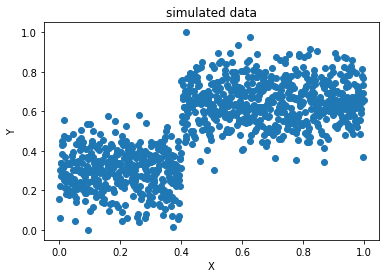

In [21]:
X = np.array(np.linspace(start = 0.001, stop = 0.999, num = n))
Y = (X > 0.4) + np.random.normal(0, 0.3, n) 
X = (X - min(X))/(max(X) - min(X)) * 0.9999 + 0.00005
Y = (Y - min(Y))/(max(Y) - min(Y)) * 0.9999 + 0.00005
plt.scatter(X, Y);
plt.xlabel('X')
plt.ylabel('Y')
plt.title('simulated data')
Y0 = Y.copy()

depth = 1

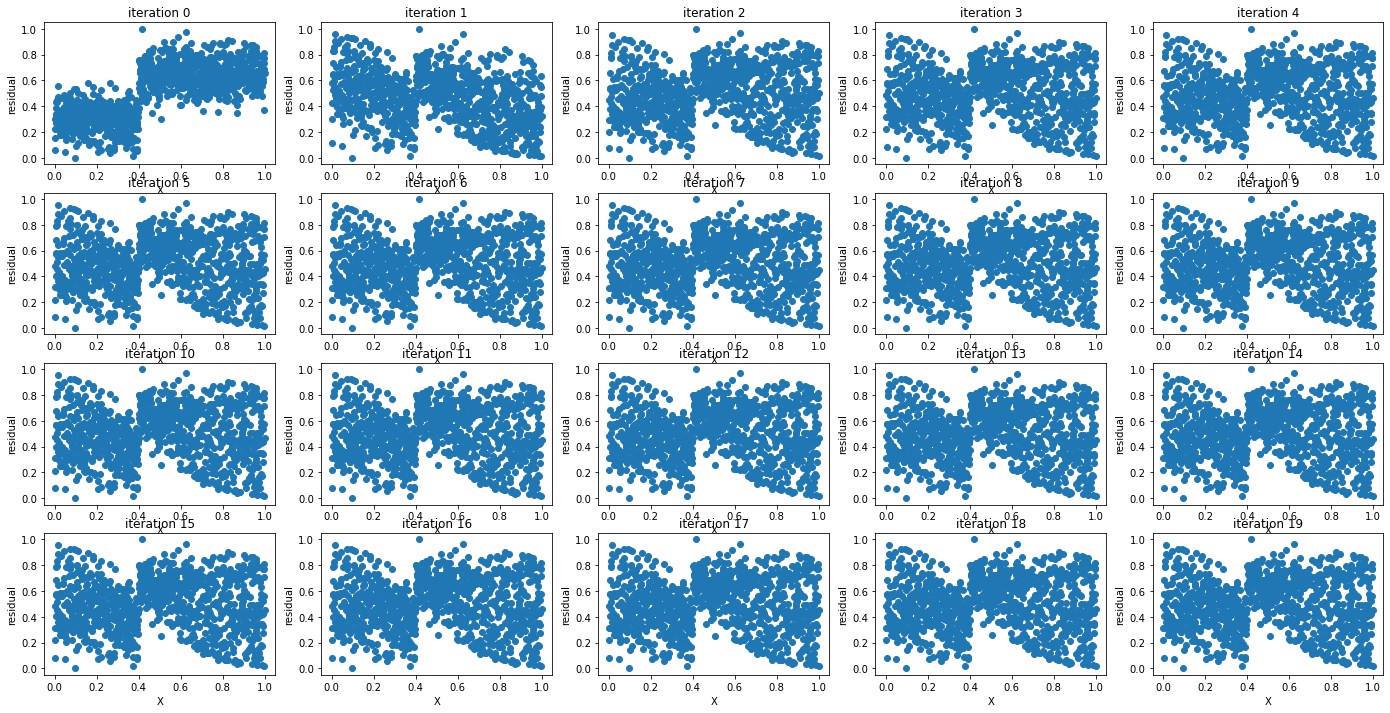

In [22]:
res = Y0.copy()
plt.figure(figsize=(24, 12))
for iter in range(20): 
    plt.subplot(4, 5, iter + 1);
    plt.scatter(X, np.array(res).reshape(len(res)), label = iter);
    plt.title(f'iteration {iter}');
    plt.xlabel('X');
    plt.ylabel('residual');
    Y = np.array(res.copy())
    for max_depth in [1]:
        tree = TreeNode(split = 0.5, left_bound=0, right_bound=1)
        curr_depth = 1
        # level traversal
        queue = [tree]
        while curr_depth <= max_depth and queue:
            l = len(queue)
            for i in range(l):
                node = queue.pop(0)
                if np.sum(np.logical_and(Y > node.left_bound, Y <= node.right_bound)) == 0:
                    node.pleft = 0.5
                elif np.sum(np.logical_and(Y > node.left_bound, Y <= node.split)) == 0:
                    node.pleft = 0.0
                elif np.sum(np.logical_and(Y > node.split, Y <= node.right_bound)) == 0:
                    node.pleft = 1.0
                else:
                    model = LogisticRegression(solver='liblinear', random_state=0)
                    local_index = np.logical_and(Y > node.left_bound, Y <= node.right_bound)
                    y_local = Y[local_index]
                    x_local = X[local_index]
                    model.fit(x_local.reshape(-1, 1), (y_local > node.split).astype('int'))
                    node.theta = [model.intercept_, model.coef_]
                    # node.pleft = model.predict_proba(x_local)[:,0]
                node.left = TreeNode(split = (node.left_bound + node.split)/2, left_bound=node.left_bound, right_bound=node.split)
                node.right = TreeNode(split = (node.right_bound + node.split)/2, left_bound=node.split, right_bound=node.right_bound)
                queue.append(node.left)
                queue.append(node.right)
            curr_depth += 1
    res = []
    for i, x in enumerate(X):
        tree_tmp = TreeNode()
        make_copy(tree, tree_tmp)
        helper(tree_tmp, x)
        res.append(tree_tmp.treecdf(Y[i]))


depth = 4

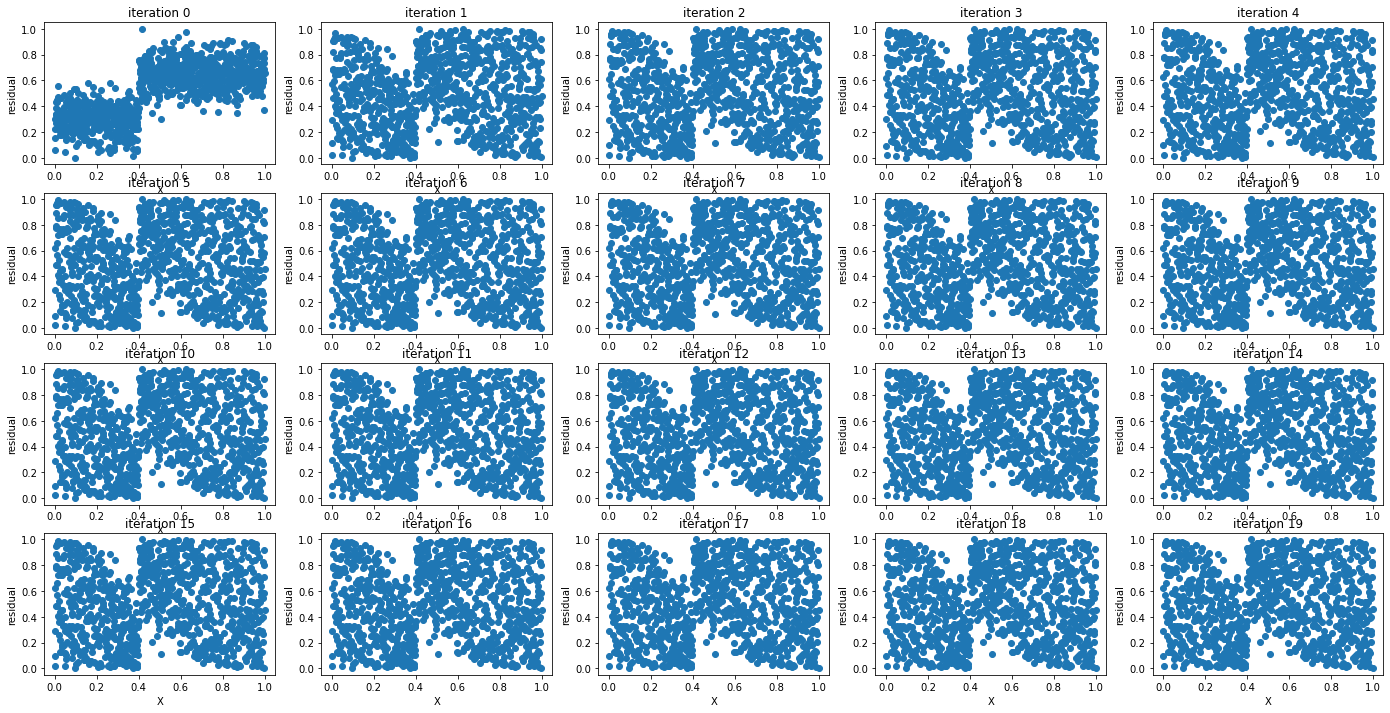

In [24]:
res = Y0.copy()
plt.figure(figsize=(24, 12))
for iter in range(20): 
    plt.subplot(4, 5, iter + 1);
    plt.scatter(X, np.array(res).reshape(len(res)), label = iter);
    plt.title(f'iteration {iter}');
    plt.xlabel('X');
    plt.ylabel('residual');
    Y = np.array(res.copy())
    for max_depth in [4]:
        tree = TreeNode(split = 0.5, left_bound=0, right_bound=1)
        curr_depth = 1
        # level traversal
        queue = [tree]
        while curr_depth <= max_depth and queue:
            l = len(queue)
            for i in range(l):
                node = queue.pop(0)
                if np.sum(np.logical_and(Y > node.left_bound, Y <= node.right_bound)) == 0:
                    node.pleft = 0.5
                elif np.sum(np.logical_and(Y > node.left_bound, Y <= node.split)) == 0:
                    node.pleft = 0.0
                elif np.sum(np.logical_and(Y > node.split, Y <= node.right_bound)) == 0:
                    node.pleft = 1.0
                else:
                    model = LogisticRegression(solver='liblinear', random_state=0)
                    local_index = np.logical_and(Y > node.left_bound, Y <= node.right_bound)
                    y_local = Y[local_index]
                    x_local = X[local_index]
                    model.fit(x_local.reshape(-1, 1), (y_local > node.split).astype('int'))
                    node.theta = [model.intercept_, model.coef_]
                    # node.pleft = model.predict_proba(x_local)[:,0]
                node.left = TreeNode(split = (node.left_bound + node.split)/2, left_bound=node.left_bound, right_bound=node.split)
                node.right = TreeNode(split = (node.right_bound + node.split)/2, left_bound=node.split, right_bound=node.right_bound)
                queue.append(node.left)
                queue.append(node.right)
            curr_depth += 1
    res = []
    for i, x in enumerate(X):
        tree_tmp = TreeNode()
        make_copy(tree, tree_tmp)
        helper(tree_tmp, x)
        res.append(tree_tmp.treecdf(Y[i]))
